<a href="https://colab.research.google.com/github/Doongka/GHDColabExamples/blob/master/BRIS05_LM003_3ParamOut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/23_Time-Series-Prediction.ipynb



In [0]:
import numpy as np
np.set_printoptions(precision=2)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd
pd.options.display.max_rows = 999

import math
from random import randint
import random
from datetime import datetime

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Activation, LSTM, CuDNNLSTM, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard # ReduceLROnPlate

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

raw=pd.read_csv(".\\04_RegionCSV\\Bris05.csv",skiprows=1,index_col=0)

raw = raw.fillna(0)
raw.head()


,runId,Time,Hus,Hds,Htrib,RoC,Qus,Qds,Qtrib,Vol
0,1.0,0.000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.167,12.9969,7.2121,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.333,12.9969,7.2121,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.500,12.9969,7.2121,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.667,12.9969,7.2121,0.0,0.0,0.0,0.0,0.0,0.0


## Prepare the Data

Data is read from a file called, "Bris05.csv" (located in the git repository).  This file is a summarised version of the Tuflow results with results all stacked into 0 - 240hours * 90 floods * timesteps/h. It contains a table with 114072 rows with the fields (in order) of 'Time', 
* Water surface level on upstream boundary - 'Hus', 
* Water surface level on downstream boundary - 'Hds', 
* Rate of Change instaneous 'RoC',
* Flow to upstream where positive - 'Qus', 
* 'Qin', Flow to downstream where positive - 'Qds', 
* instaneous volume stored [m3] 'Vol', 
* 'check'.

The code below reads the csv files and puts the data into a dataframe for ease of use.  A training set and test set is derived from this dataframe.  The training set is used to train the LSTM model.  The test set is data that the model won't see in the training process and is used to validate the model fit.

For this model, the predictor variables are 5 timesteps worth of Inflow, ~~ROC~~ and Volume.  The response variable is Outflow.

https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
https://machinelearningmastery.com/time-series-prediction-with-deep-learning-in-python-with-keras/


### Model training mechanics

Predictors = Vol, Hds, RoC, *Htrib*

Response Targets = Qus, Hus, Qds *Qtrib* 

Feed a flow in at top and route to bottom using Tide as initial Hds and Initial Water Level and Q to derive Vol


## Load and create Target Data for prediction

#### Work on subselection of all flood events

The following selects only events 13 through 17 to analyse. 

1441.0

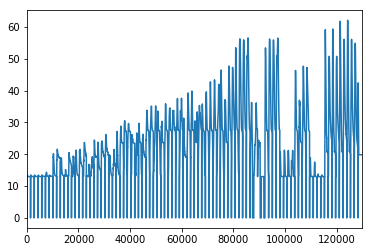

In [0]:
raw['Hus'].plot()
raw.shape[0]/90

### Shuffle the flood events

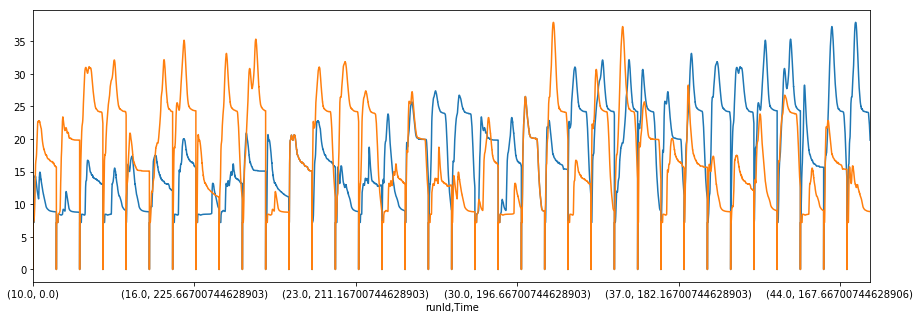

In [0]:
a,b = 10,45
dftmp = raw[raw['runId'].between(a,b)] ## Something wrong at event 68 or so
dftmp = dftmp.set_index(['runId','Time'])

qq = list(range(a,b+1))
random.shuffle(qq)

## Introducing np.nans here 
dfShuffled = dftmp.reindex(qq,level=0)

dftmp['Hds'].plot(figsize=(15,5))
dfZZ = dfShuffled.reset_index()
dfZZ['Hds'].plot(figsize=(15,5))

##  Create Test and train arrays


            Qds      Qus       Hus
count  51876.00  51876.0  51876.00
mean    1877.07      0.0     21.40
std     2339.11      0.0      6.46
min        0.00      0.0      0.00
25%      121.20      0.0     15.57
50%      759.95      0.0     20.68
75%     3501.49      0.0     27.31
max    13726.56      0.0     39.88



Training Dataset shape:(36313, 7)
Num Train: 36313


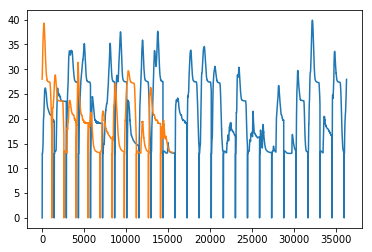

In [0]:
test_size = 0.3

df = dfShuffled.reset_index()

# read from cleansed CSV

# Create target dataframe
#Sea level, H @ Wivenhoe, H @ Bremer .....
y_val = df[["Qds",'Qus','Hus']]

## summary of response datafram
# City Gauge
print(round(y_val.describe(),2))
print('\n')

# create predictor dataframe (by dropping Y)
x_data = df.drop(["Qds",'Qus','Hus'],axis=1)
x_data = x_data[['runId','RoC','Vol','Hds']] 

## Return a Numpy array
x_values = x_data.values
y_values = y_val.values

X_train, X_test, y_train, y_test = train_test_split(x_values, y_values, shuffle=False, test_size=0.3)

num_data = len(x_values)
num_train = int((1-test_size) * num_data)
num_test = num_data - num_train

dataset_train = np.hstack((X_train, y_train))
dataset_test = np.hstack((X_test, y_test))

print('\nTraining Dataset shape:'+str(dataset_train.shape))
plt.plot(dataset_train[:,-1])
plt.plot(dataset_test[:,-1])

print('Num Train: %s'%num_train)

## Scale the test and train arrays 

In [0]:
from sklearn.preprocessing import MinMaxScaler
x_scaler = MinMaxScaler()

X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

print(X_train.shape, X_train_scaled.shape)
print(y_train.shape, y_train_scaled.shape)

dataset_train = np.hstack((X_train_scaled, y_train_scaled))
dataset_test = np.hstack((X_test_scaled, y_test_scaled))

(36313, 4) (36313, 4)
(36313, 3) (36313, 3)


### Create function for slicing arrays

In [0]:
#```python
def slicer(data, seq_in, seq_out):
    """
    Generator function for creating random batches of training-data.
        
    ['runId','RoC','Vol','Hds']
    [["Qds",'Qus','Hus']]
    
    """

    X, y = list(), list()
    for i in range(len(data) - seq_in - 1):
        fldId = data[i,0]
        
        # find end sequence length
        end_idx = i + seq_in
        
        #if data[end_idx,0] == fldId:       
        out_end_idx  = end_idx + seq_out-1

        # catch to break if we are at end of dataset
        if out_end_idx > len(data):
            break

        # gather input and output parts of the pattern
        seq_x, seq_y = data[i:end_idx, 1 : -3], data[out_end_idx-1, -3 :]

        X.append(seq_x)        
        y.append(seq_y)

    X=np.array(X)
    y=np.array(y)

    return X,y
#```

## Slice the scaled train/test arrays

False
(36306, 6, 3)


(36306, 3)

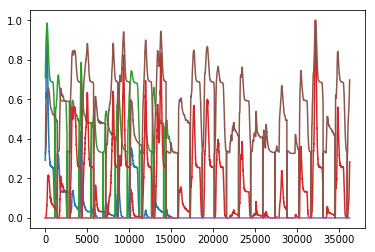

In [0]:
num_x_signals = x_values.shape[1]
num_y_signals = y_values.shape[1]

batch_size = 256

seq_length_in = 1*24*6    # 10 mins per step hrs * (60/10)
seq_length_out = 1   
num_features = 3

# generator = batch_generator(batch_size=batch_size,
#                             sequence_length=seq_length_in)

# x_batch, y_batch = next(generator)


X_train_sliced, y_train_sliced = slicer(dataset_train, seq_length_in, seq_length_out)

X_test_sliced, y_test_sliced = slicer(dataset_test, seq_length_in, seq_length_out)

plt.plot(y_test_sliced)
plt.plot(y_train_sliced)
print(np.isnan(X_train_sliced).any())

print(X_train_sliced.shape)
y_train_sliced.shape

In [0]:
validation_data = (np.expand_dims(X_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

## Build and compile the model

In [0]:
X_train_scaled.shape, y_train_scaled.shape

((36313, 4), (36313, 3))

In [0]:
num_y_signals
#num_features

3

In [0]:
print(' Shape of X Train: {0}\n Shape of Y Train: {1}\n No. of Y outputs: {2}'.format(X_train_sliced.shape, y_train_sliced.shape, num_y_signals))
hidden_nodes = 32
layers = 3

model = Sequential()

model.add(CuDNNLSTM(hidden_nodes, return_sequences=True, input_shape=(seq_length_in, num_features)))
model.add(CuDNNLSTM(hidden_nodes, return_sequences=True, input_shape=(seq_length_in, num_features)))
model.add(CuDNNLSTM(hidden_nodes, return_sequences=True, input_shape=(seq_length_in, num_features)))
model.add(CuDNNLSTM(hidden_nodes, input_shape=(seq_length_in, num_features)))

#model.add(LSTM(hidden_nodes, activation='relu', return_sequences=True, recurrent_dropout=0.2, return_state=False, input_shape=(seq_length_in, num_features)))
#model.add(LSTM(hidden_nodes, activation='relu', return_sequences=True, recurrent_dropout=0.2, return_state=False, input_shape=(seq_length_in, num_features)))
#model.add(LSTM(hidden_nodes, activation='relu'))

model.add(Dense(num_y_signals,activation='tanh')) # Activations??

model = multi_gpu_model(model, gpus=2)

## Learning Rate, how fast it approaches a solution
#adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999)#, epsilon=None, decay=0, amsgrad=False)
#RMSprop = RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='binary_crossentropy', optimizer='adam')

print(model.summary())

 Shape of X Train: (36306, 6, 3)
 Shape of Y Train: (36306, 3)
 No. of Y outputs: 3
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cu_dnnlstm_16_input (InputLayer (None, 6, 3)         0                                            
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 6, 3)         0           cu_dnnlstm_16_input[0][0]        
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 6, 3)         0           cu_dnnlstm_16_input[0][0]        
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 3)            30179       lambda_6[0][0]                   
                         

## Train Model - NOTE: Only run this to retrain model 

This section is the core of the model.  Here the model is constructed by defining the number of layers and neurons, and also the type of neurons to be used (we have used LSTM and Perceptron cells.).

The model is then fed the training data and is optimized using the ADAM optimization algorithm.  A relatively high learning rate was found to provide the best fit.  (ADAM default learning rate is 0.001 not 0.1).The trained model is saved to a H5 file. Average mean squared error at the end of a 200 epoch training run is less than 1.




In [0]:
###                                   ###  C:\program files\
# ------------------------------------  # 
###                                   ###

modelname = datetime.now().strftime("%Y%m%d-%H%M")+'_Bris05_3ParamOutput_{0}nodes_{1}layers'.format(hidden_nodes,layers)

batchSize = 2048
epochs=100  #=25*(10**3)  # 4e5 Ideal from previous run 

# Set up callbacks for Tensorboard
callback_tensorboard = TensorBoard(log_dir='./logs01/'+datetime.now().strftime("%Y%m%d-%H%M"),
                                   write_graph=True,
                                   write_grads=True)                                  
callbacks = [callback_tensorboard]
print('./logs01/'+datetime.now().strftime("%Y%m%d-%H%M"))

## Ignore Flood ID 
history = model.fit(X_train_sliced, y=y_train_sliced, epochs=epochs, batch_size=batchSize, verbose=1, shuffle = False, callbacks=callbacks)

./logs01/20190724-1234
Epoch 1/100
36306/36306 [==============================] - 0s 13us/sample - loss: 0.3137
Epoch 2/100
36306/36306 [==============================] - 0s 12us/sample - loss: 0.3138
Epoch 3/100
36306/36306 [==============================] - 0s 12us/sample - loss: 0.3138
Epoch 4/100
36306/36306 [==============================] - 0s 12us/sample - loss: 0.3137
Epoch 5/100
36306/36306 [==============================] - 0s 12us/sample - loss: 0.3137
Epoch 6/100
36306/36306 [==============================] - 0s 12us/sample - loss: 0.3137
Epoch 7/100
36306/36306 [==============================] - 0s 12us/sample - loss: 0.3137
Epoch 8/100
36306/36306 [==============================] - 0s 12us/sample - loss: 0.3138
Epoch 9/100
36306/36306 [==============================] - 0s 12us/sample - loss: 0.3139
Epoch 10/100
36306/36306 [==============================] - 0s 12us/sample - loss: 0.3137
Epoch 11/100
36306/36306 [==============================] - 0s 12us/sample - loss: 0.3

36306/36306 [==============================] - 0s 11us/sample - loss: 0.3138
Epoch 92/100
36306/36306 [==============================] - 0s 12us/sample - loss: 0.3136
Epoch 93/100
36306/36306 [==============================] - 0s 11us/sample - loss: 0.3136
Epoch 94/100
36306/36306 [==============================] - 0s 12us/sample - loss: 0.3137
Epoch 95/100
36306/36306 [==============================] - 0s 11us/sample - loss: 0.3136
Epoch 96/100
36306/36306 [==============================] - 0s 11us/sample - loss: 0.3135
Epoch 97/100
36306/36306 [==============================] - 0s 11us/sample - loss: 0.3136
Epoch 98/100
36306/36306 [==============================] - 0s 11us/sample - loss: 0.3137
Epoch 99/100
36306/36306 [==============================] - 0s 11us/sample - loss: 0.3138
Epoch 100/100
36306/36306 [==============================] - 0s 11us/sample - loss: 0.3148


## Performance on Test-Set

We can now evaluate the model's performance on the test-set. This function expects a batch of data, but we will just use one long time-series for the test-set, so we just expand the array-dimensionality to create a batch with that one sequence.


15556/15556 [==============================] - 7s 455us/sample - loss: 0.2905
loss (test-set): 0.2905468660413713


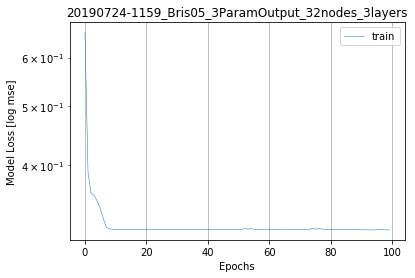

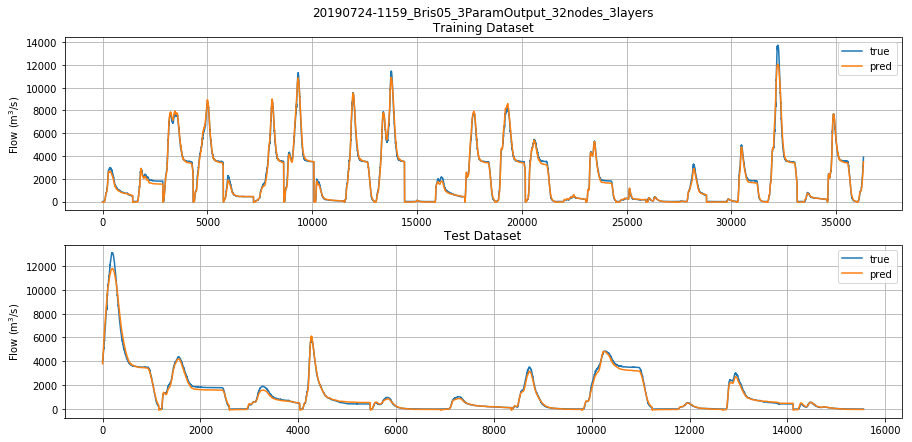

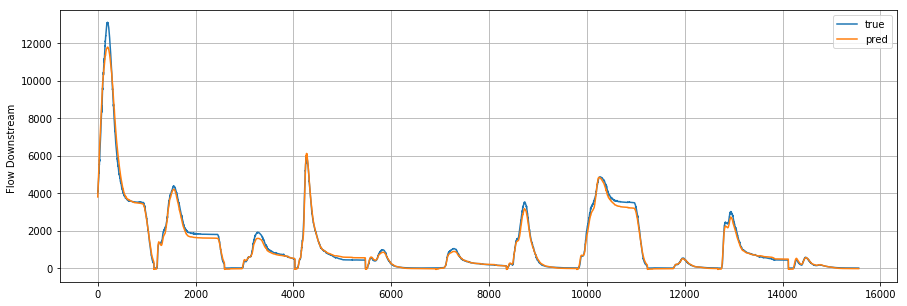

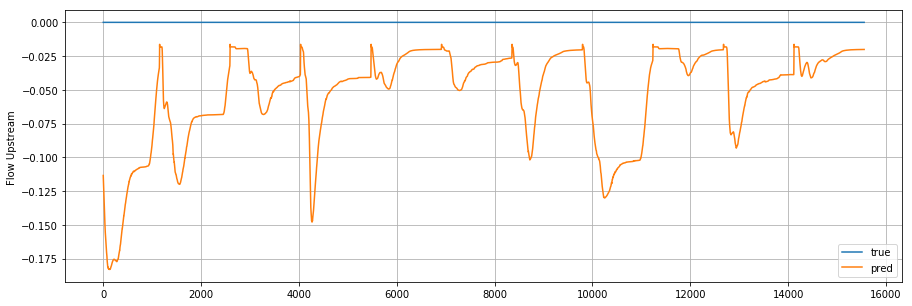

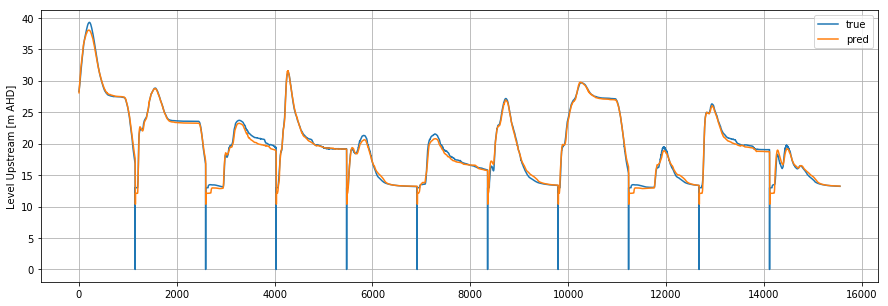

Validation Set R-Square -0.048547814130941114


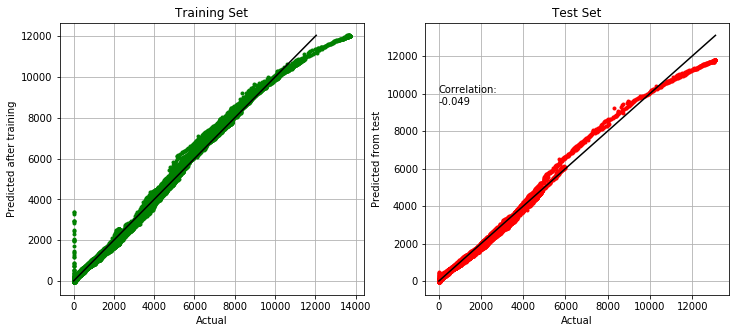

In [0]:
result = model.evaluate(x=X_test_sliced,y=y_test_sliced)


print("loss (test-set):", result)

### - PLOT ONE
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='train',linewidth=0.5)
ax.grid()
ax.semilogy()
ax.set_xlabel('Epochs')
ax.set_ylabel('Model Loss [log mse]')
ax.legend()
ax.set_title(modelname)

fig.savefig('01_'+modelname+'_scaled_gpu.png')


### - PLOT Two
plot_comparison(modelname)


### - PLOT Three
# Plot actual vs predition for training set
y_test_pred = model.predict(X_test_sliced)
y_test_pred_rescaled = y_scaler.inverse_transform(y_test_pred)
y_test_rescaled = y_scaler.inverse_transform(y_test_sliced)


y_train_pred = model.predict(X_train_sliced)
y_train_pred_rescaled = y_scaler.inverse_transform(y_train_pred)
y_train_rescaled = y_scaler.inverse_transform(y_train_sliced)

#Compute R-Square value for validation set
RSqrdTest = r2_score(y_test_pred_rescaled, y_test_rescaled)
print("Validation Set R-Square",RSqrdTest)

### - PLOT Four
fig,(ax0,ax1) = plt.subplots(ncols=2,figsize=(12,5))

ax0.plot(y_train_rescaled, y_train_pred_rescaled,'g.')
ax0.plot([6,y_train_pred_rescaled.max()],[6,y_train_pred_rescaled.max()],'k')
ax0.grid()
ax0.set_title('Training Set')
ax0.set_xlabel('Actual')
ax0.set_ylabel('Predicted after training')



ax1.plot(y_test_rescaled,y_test_pred_rescaled,'r.')
ax1.plot([6,y_test.max()],[6,y_test.max()],'k')
ax1.grid()
ax1.set_title('Test Set')
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted from test')
ax1.text(10,0.8*y_test_pred_rescaled.max(),'Correlation:\n{}'.format(round(RSqrdTest,3)))

fig.savefig('03_'+modelname+'Performformance.png')

In [0]:
target_names = ['Flow Downstream ', 'Flow Upstream ', 'Level Upstream [m AHD]']

"""
   [["Qds",'Qus','Hus']]
Plot the predicted and true output-signals.

:param start_idx: Start-index for the time-series.
:param length: Sequence-length to process and plot.
:param train: Boolean whether to use training- or test-set.
"""
def plot_comparison(modelname):
    
    fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(15,7))

    lst = [True, False]

    for g in lst:
        train = g
        if train:
            # Use training-data.
            ttl = '{}\n Training Dataset '.format(modelname)
            x = X_train_sliced
            y_train_rescaled = y_scaler.inverse_transform(y_train_sliced)
            y_true = y_train_rescaled
            ax = ax0
        else:
            # Use test-data.
            ttl = 'Test Dataset'
            x = X_test_sliced
            y_test_rescaled = y_scaler.inverse_transform(y_test_sliced)
            y_true = y_test_rescaled
            ax = ax1

        # Use the model to predict the output-signals.
        y_pred = model.predict(x)

        # The output of the model is between 0 and 1.
        # Do an inverse map to get it back to the scale
        # of the original data-set.
        y_pred_rescaled = y_scaler.inverse_transform(y_pred)#[0])

        # Plot and compare the two signals.
        ax.plot(y_true[:,0], label='true')
        ax.plot(y_pred_rescaled[:,0], label='pred')

        # Plot grey box for warmup-period.
        #p = plt.axvspan(0, facecolor='black', alpha=0.15)

        # Plot labels etc.
        ax.set_ylabel('Flow (m$^3$/s)')
        ax.set_title(ttl)
        ax.grid()
        ax.legend()

        if train == False:
            for signal in range(len(target_names)):
                # Get the output-signal predicted by the model.
                signal_pred = y_pred_rescaled[:, signal]

                # Get the true output-signal from the data-set.
                signal_true = y_true[:, signal]

                # Make the plotting-canvas bigger.
                plt.figure(figsize=(15,5))

                # Plot and compare the two signals.
                plt.plot(signal_true, label='true')
                plt.plot(signal_pred, label='pred')

                # Plot labels etc.
                plt.ylabel(target_names[signal])
                plt.grid()
                plt.legend()
                plt.savefig('Model_Test_Validation_{0}_{1}.png'.format(modelname,target_names[signal]),dpi=300)



    plt.show()
    fig.savefig('Model_Validation_{}.png'.format(modelname),dpi=300)
    